In [1]:
%matplotlib notebook
import ipywidgets as widgets
from ipywidgets import *
import numpy as np
from skimage.transform import hough_circle, hough_circle_peaks, rotate
from skimage.feature import canny
from skimage.draw import circle_perimeter
import matplotlib.pyplot as plt
from scipy import signal
from time import time

In [2]:
# Constants (magic numbers, knobs we can tweak)
CAN_SIG = 5  # Canny sigma to use
CAN_LOW = 0.95  # Canny low threshold
CAN_HI = 0.99  # Canny high threshold
PK_DIST = 15. # Minimum pixel width between projection peaks
PK_SIG = 4. # Number of standard deviations to identify peaks in projection

<IPython.core.display.Javascript object>


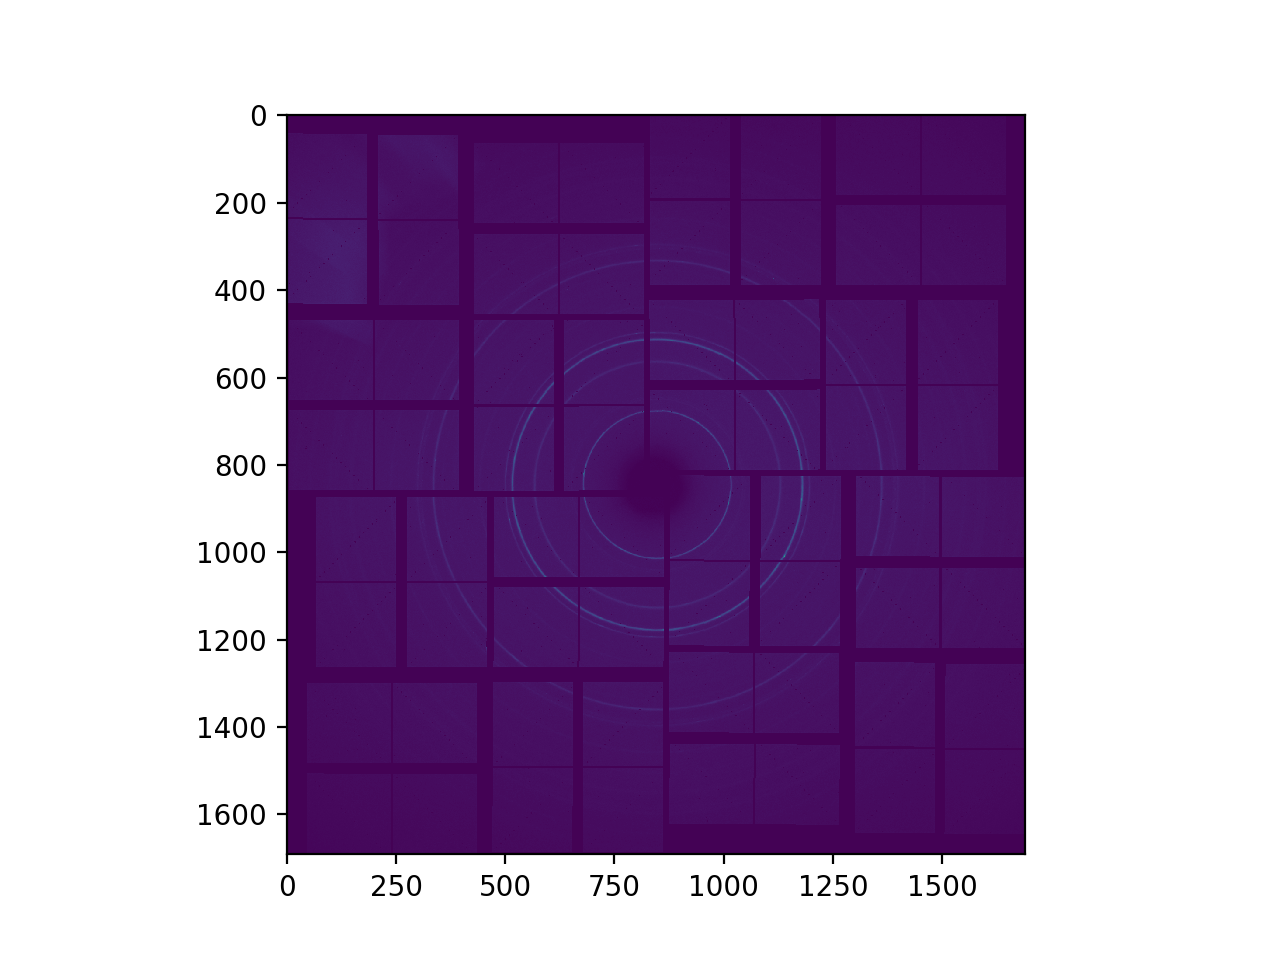

In [3]:
# Get image and mask
start = time()
#im = np.load('test_data/AvImg_xppn3416_Run200.npy')
#mask = np.load('test_data/AvImg_xppn3416_Run200_mask.npy')
im = np.load('test_data/AvImg_xppo5616_Run716.npy')
mask = np.load('test_data/AvImg_xppo5616_Run716_mask.npy')
plt.figure()
plt.imshow(im)
plt.show()

<IPython.core.display.Javascript object>


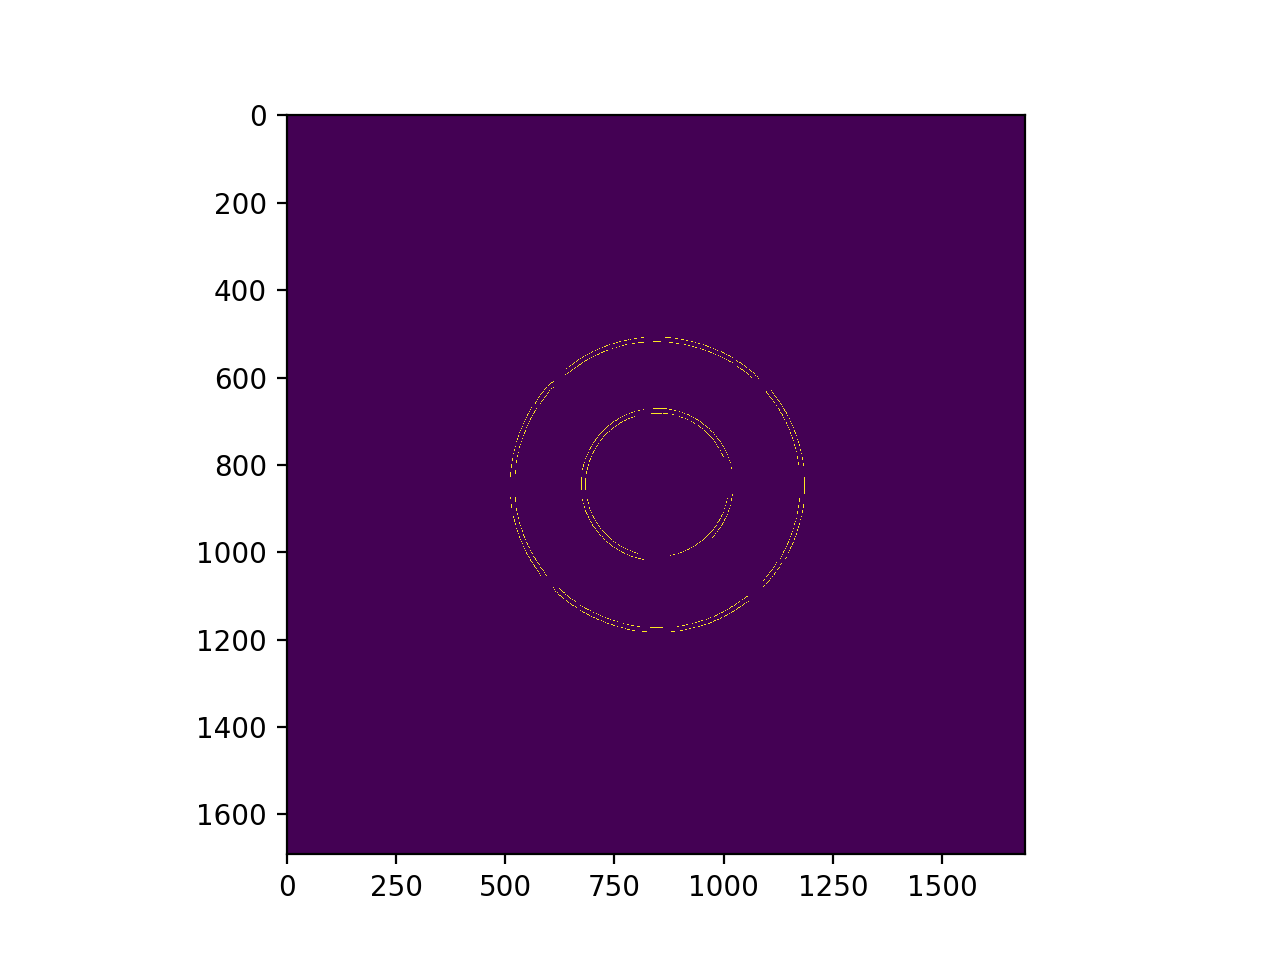

In [4]:
# Use Canny to find edges
edges = canny(im, mask=mask.astype(bool), sigma=CAN_SIG, low_threshold=CAN_LOW, \
        high_threshold=CAN_HI, use_quantiles=True).astype(int)
plt.figure()
plt.imshow(edges)
plt.show()

In [5]:
# Get Projection and std in x and y
proj_x = edges.sum(axis=0)
proj_y = edges.sum(axis=1)
std_x = np.std(proj_x)
std_y = np.std(proj_y)

<IPython.core.display.Javascript object>


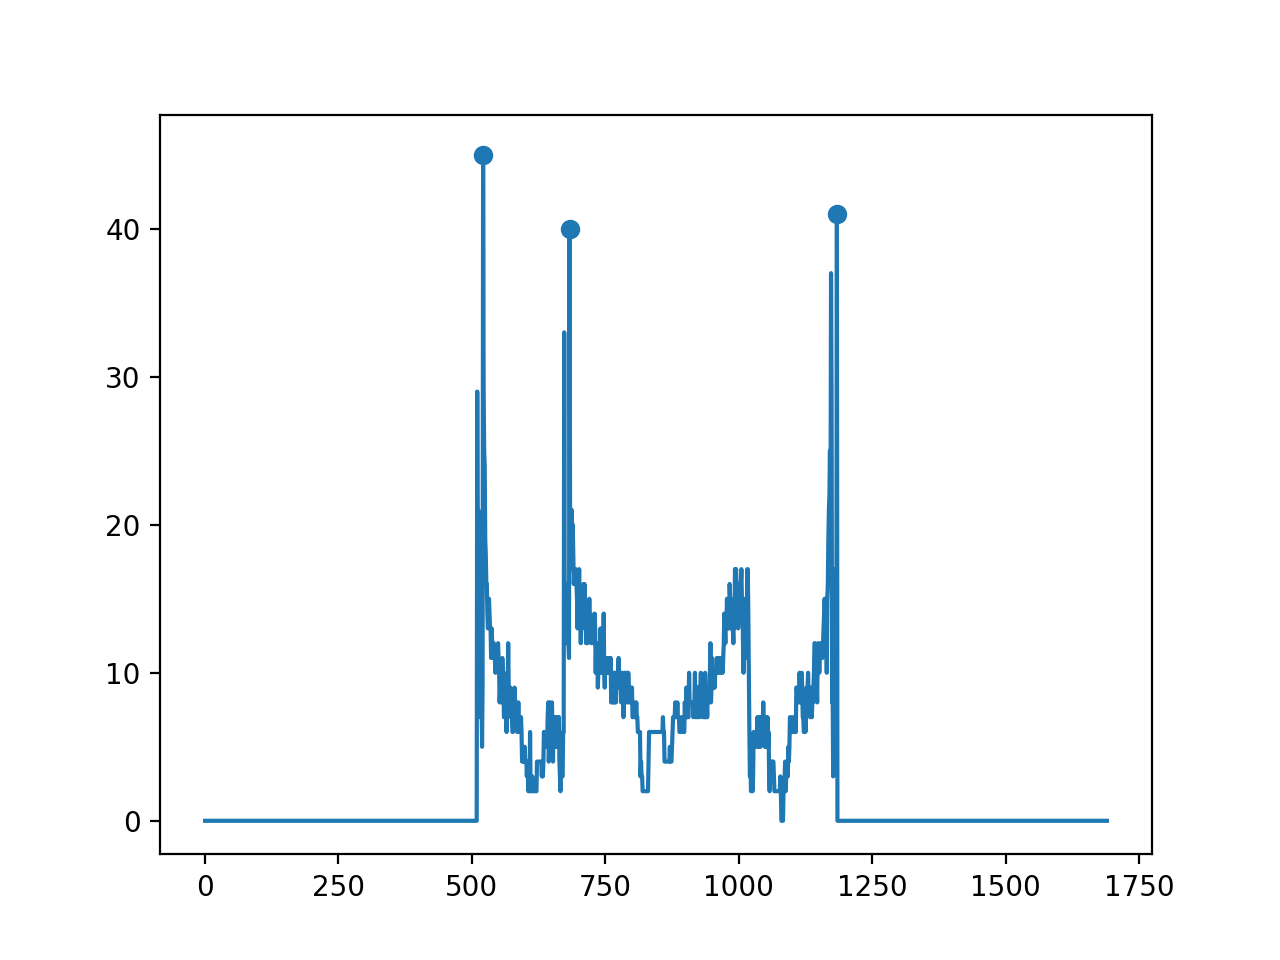

<IPython.core.display.Javascript object>


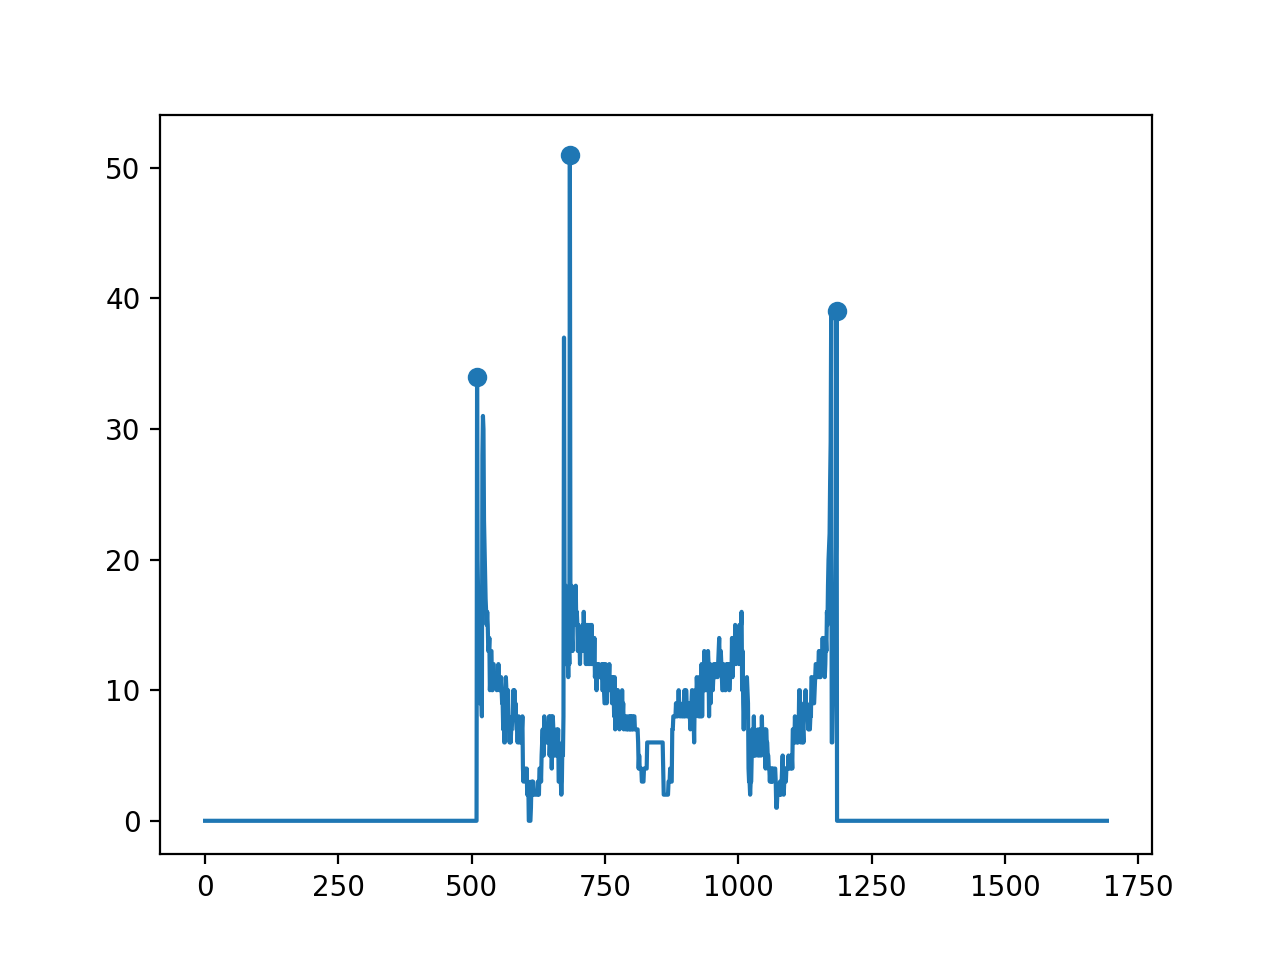

In [6]:
# Find peaks in x and y and plot on projection, can define distance and height to filter out noise
peaks_x = signal.find_peaks(proj_x, height=PK_SIG*std_x, distance=PK_DIST)
peaks_y = signal.find_peaks(proj_y, height=PK_SIG*std_y, distance=PK_DIST)
plt.figure()
plt.plot(proj_x)
plt.scatter(peaks_x[0], peaks_x[1]['peak_heights'])
plt.figure()
plt.plot(proj_y)
plt.scatter(peaks_y[0], peaks_y[1]['peak_heights'])
plt.show()

In [7]:
# Pull out peaks within some value of each other
print('peaks x ', peaks_x)
print('peaks y ', peaks_y)

('peaks x ', (array([ 521,  683, 1184]), {'peak_heights': array([45., 40., 41.])}))
('peaks y ', (array([ 510,  684, 1184]), {'peak_heights': array([34., 51., 39.])}))


In [8]:
# Pick which set of peaks to use, this needs more smarts to be robust
if len(peaks_x[0]) % 2 is 0:
    peaks_use = peaks_x[0]
elif len(peaks_y[0]) % 2 is 0:
    peaks_use = peaks_y[0]
else:
    peaks_use = peaks_x[0]
    print('peaks not detected symmetrically, expect a skew error')

peaks not detected symmetrically, expect a skew error


<IPython.core.display.Javascript object>


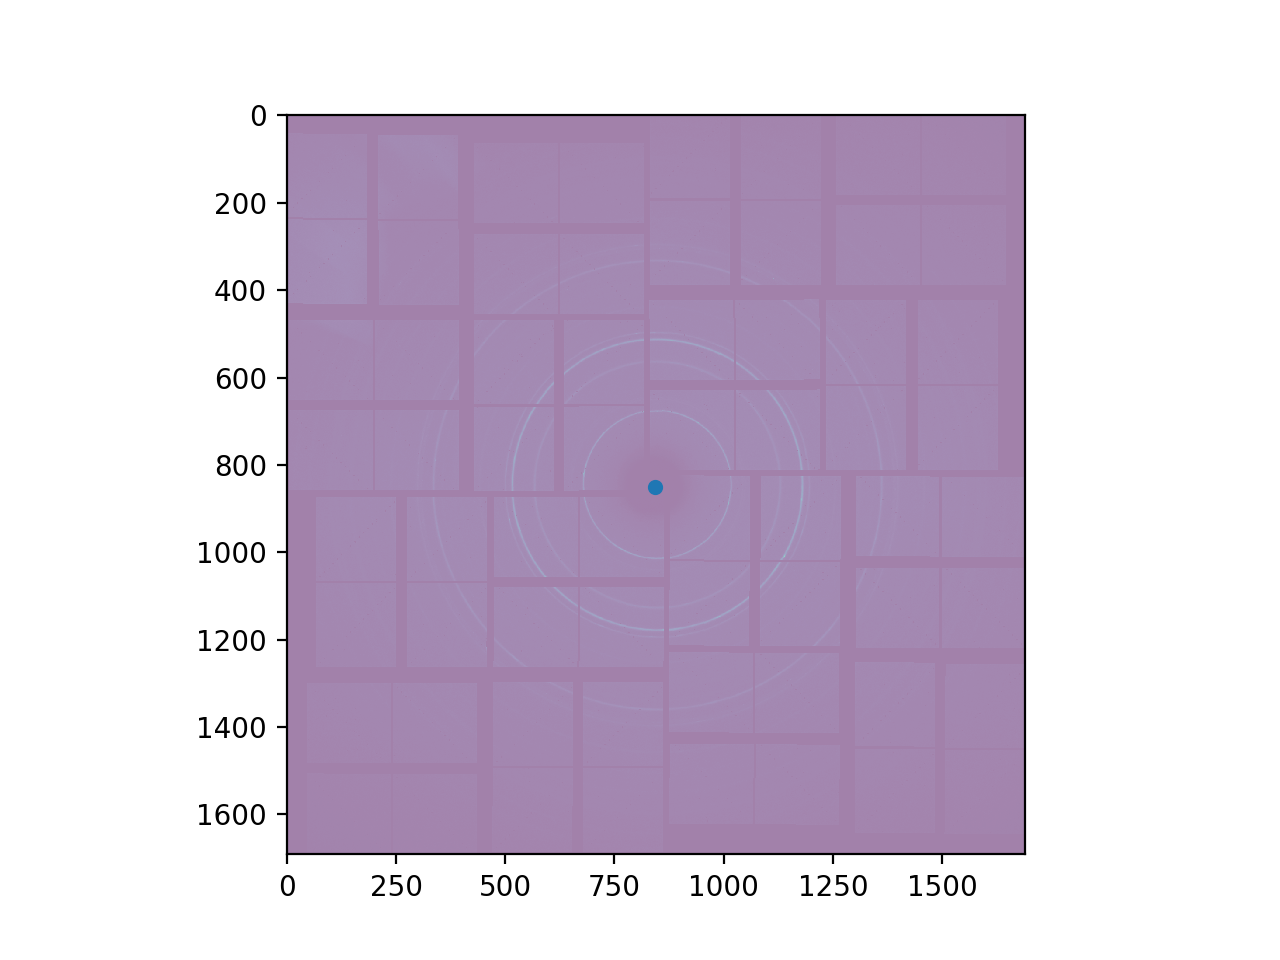

In [9]:
# Guess radius for each circle, do hough circle and plot
plt.figure()
plt.imshow(im, alpha=0.5)
peak_idx_list = peaks_use.tolist()
cen_x = []
cen_y = []
while len(peak_idx_list) > 1:
    rad_guess = int((peak_idx_list.pop() - peak_idx_list.pop(0)) / 2)
    hough_radii = np.arange(rad_guess-2, rad_guess+2, 2)
    hough_res = hough_circle(edges, hough_radii)
    accums, cx, cy, radii = \
        hough_circle_peaks(hough_res, hough_radii, total_num_peaks=1)
    for center_y, center_x, radius in zip(cy, cx, radii):
        circy, circx = circle_perimeter(center_y, center_x, radius,
                                    shape=im.shape)
        #plt.scatter(circy, circx, s=10)
        cen_x.append(center_x)
        cen_y.append(center_y)

In [10]:
# STD and Mean of center values
std_cen_x = np.std(cen_x)
std_cen_y = np.std(cen_y)
mean_cen_x = np.mean(cen_x)
mean_cen_y = np.mean(cen_y)

# Calculate low and high thresholds for center point to be included
low_x = mean_cen_x - std_cen_x
low_y = mean_cen_y - std_cen_y
hi_x = mean_cen_x + std_cen_x
hi_y = mean_cen_y + std_cen_y

# Get the center fitting result
res_x = np.mean([x for x in cen_x if low_x <= x <= hi_x])
res_y = np.mean([y for y in cen_y if low_y <= y <= hi_y])
print('center location x: ', res_x, ' center location x: ', res_y)
plt.scatter(np.mean(res_x), np.mean(res_y), s=20)
plt.show()
print(' time ', time() - start)

('center location x: ', 842.0, ' center location x: ', 851.0)
(' time ', 1.5068809986114502)
